### step - 1

Completed


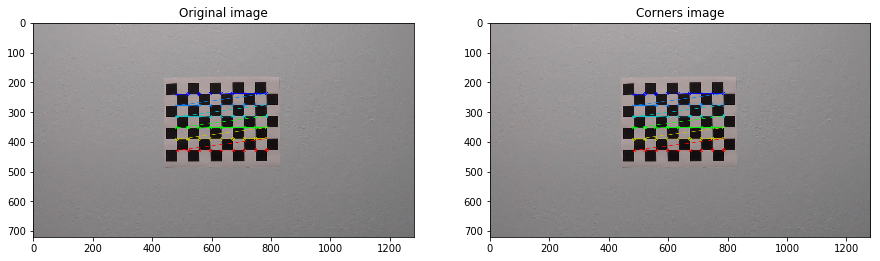

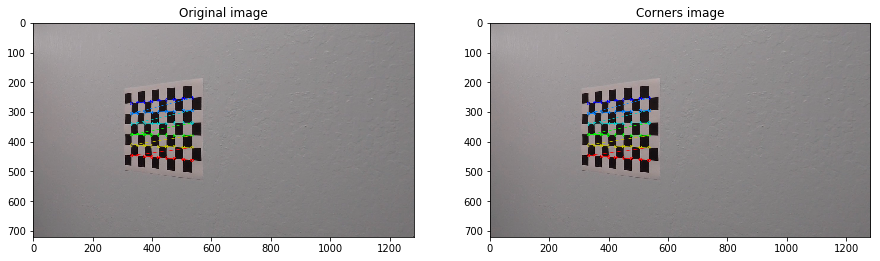

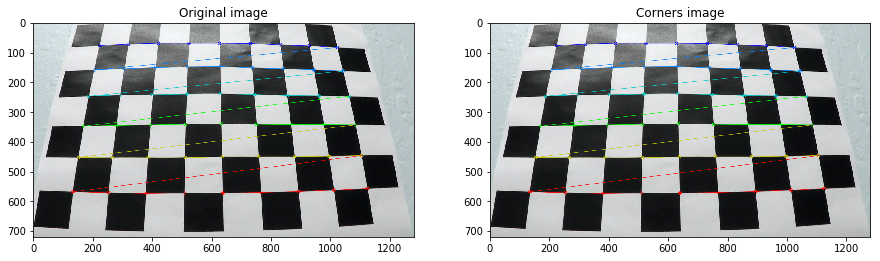

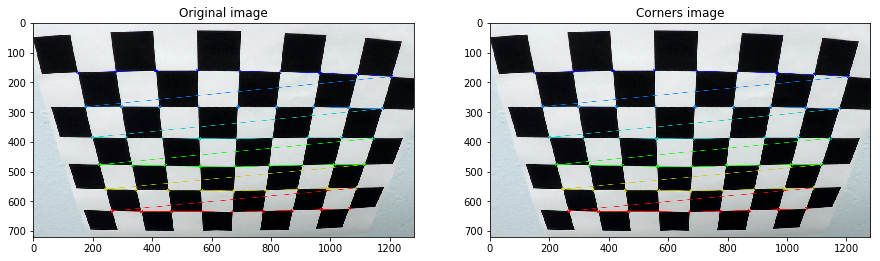

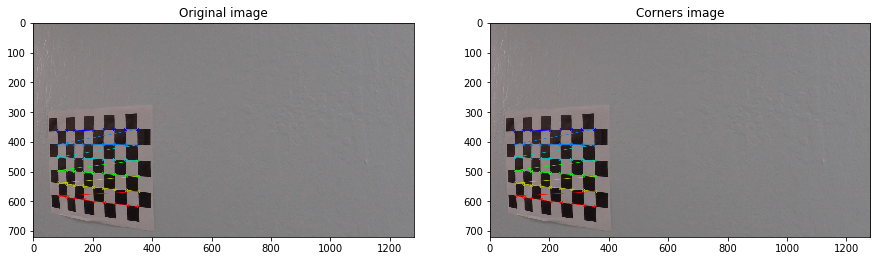

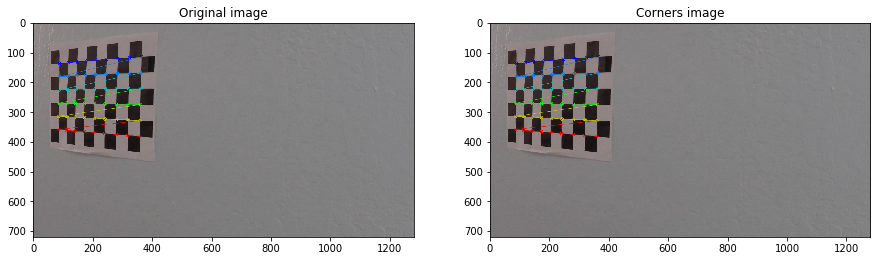

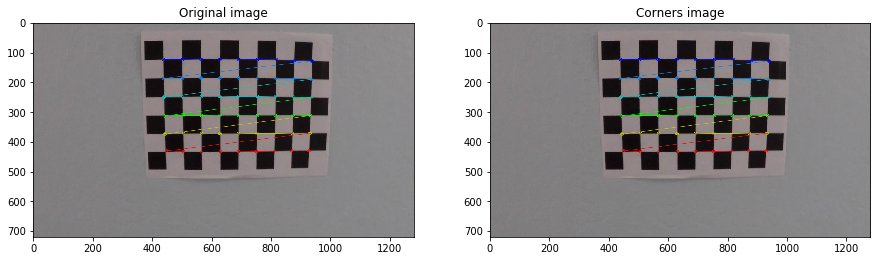

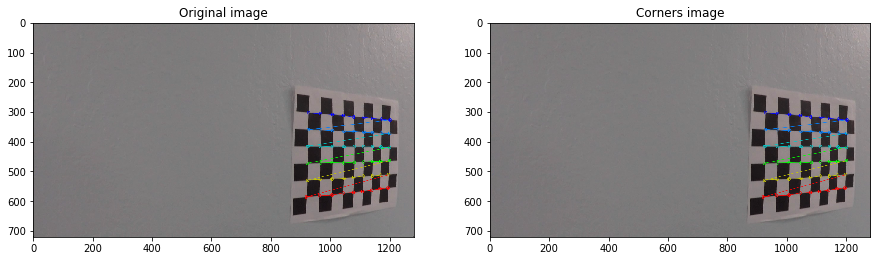

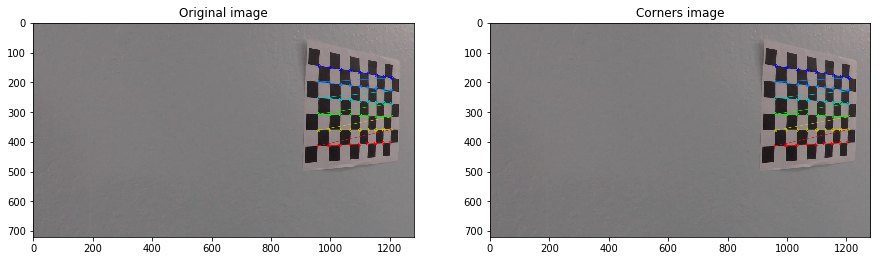

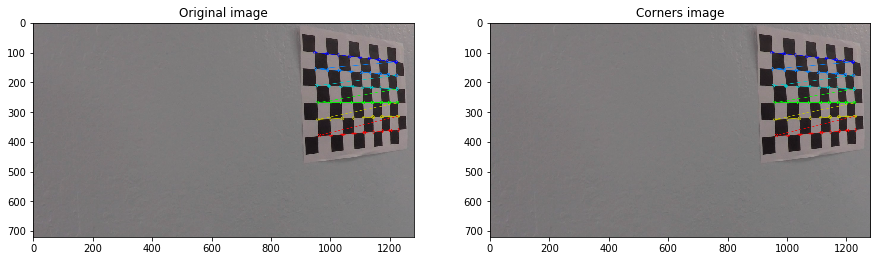

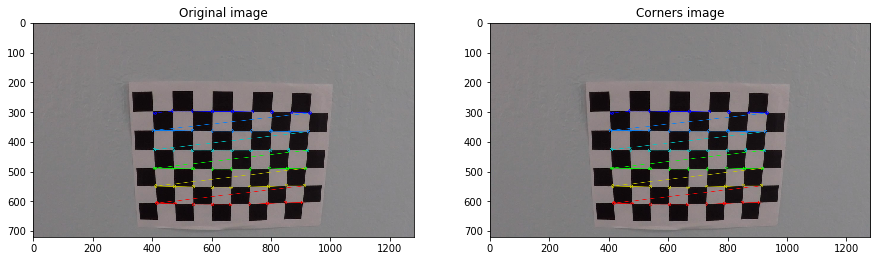

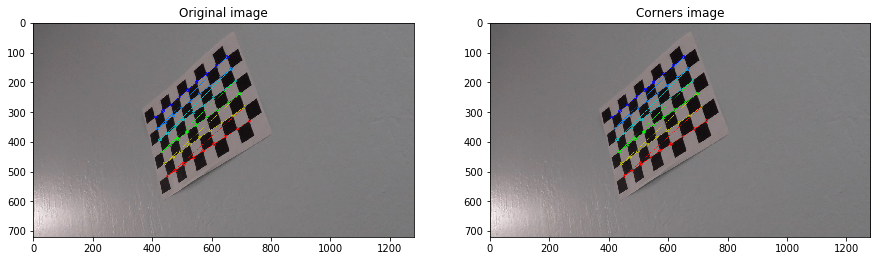

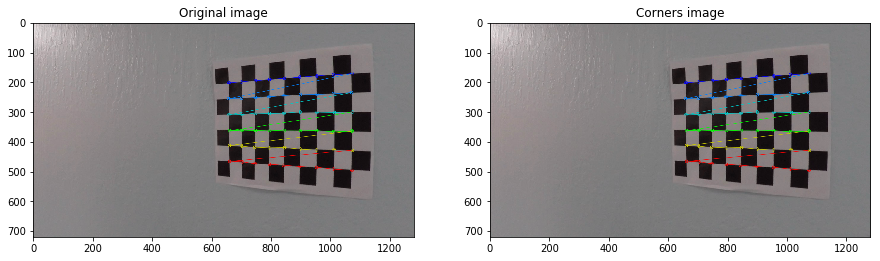

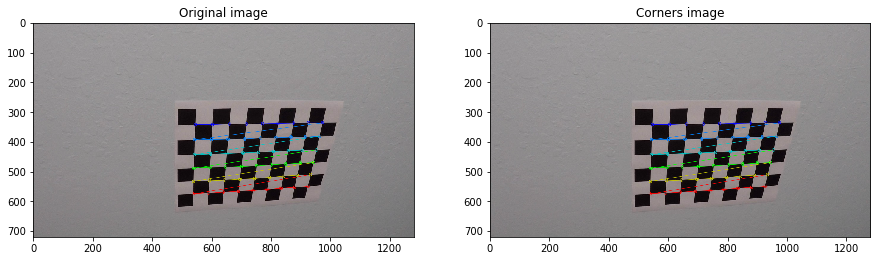

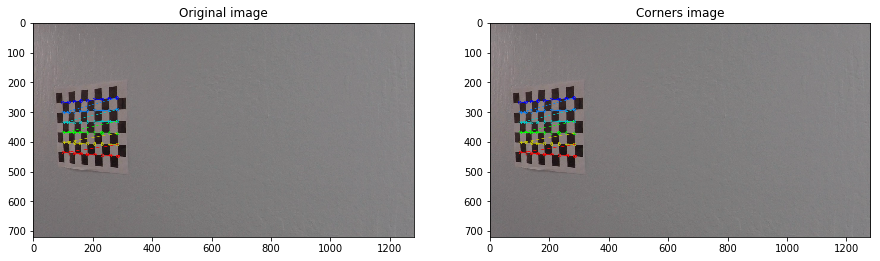

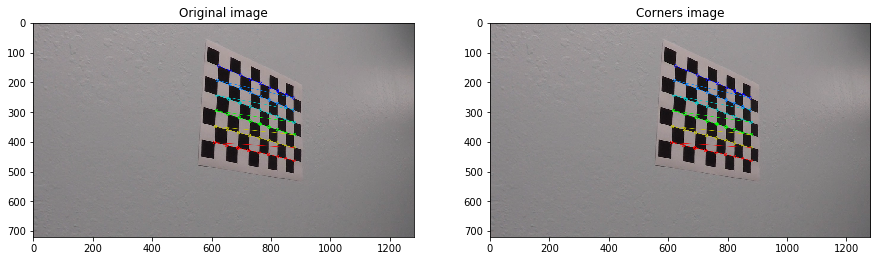

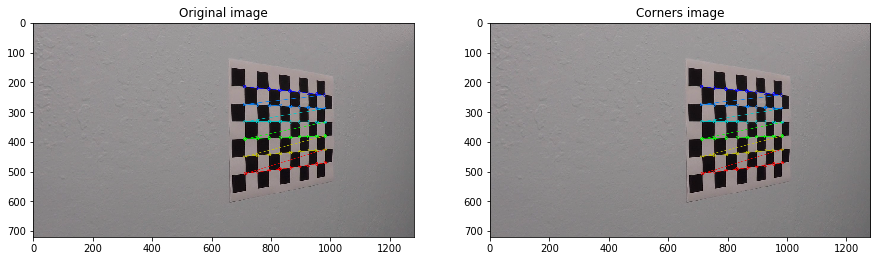

In [1]:
# Camera Calibration matrix and distortion coefiicients 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Arrays to store object points and image points from all the images
objPoints = []
imgPoints = []
 
# prepare object points 
objP = np.zeros((6*9,3), np.float32)
objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

imgContainer = glob.glob('camera_cal/*.jpg')

## finding and drawing the image corners on the image
for i, imgName in enumerate(imgContainer):
    image = cv2.imread(imgName)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objP)
        f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        axs1.set_title("Original image")
        axs1.imshow(image)
        axs2.set_title("Corners image")
        axs2.imshow(img)



print("Completed")


### step - 2

In [2]:
## calibrating the camera and undistorting the image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

print("Completed")

Completed


Completed


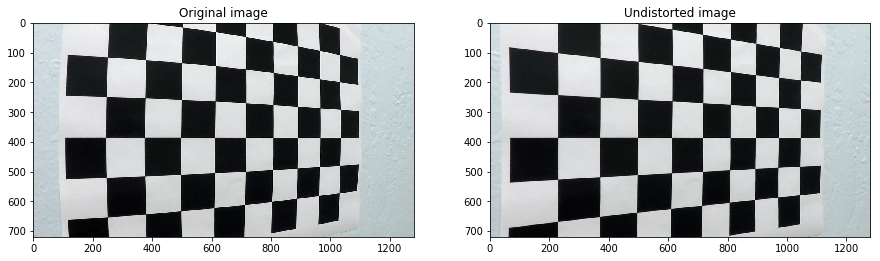

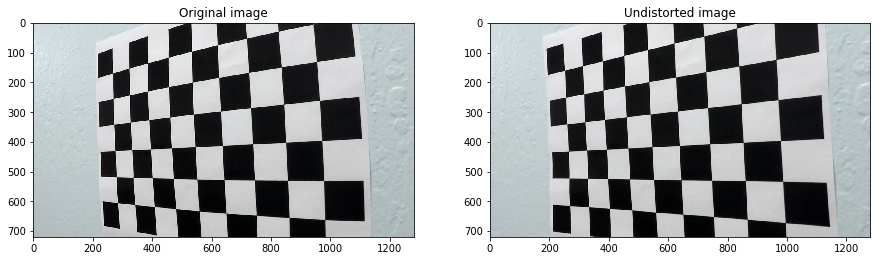

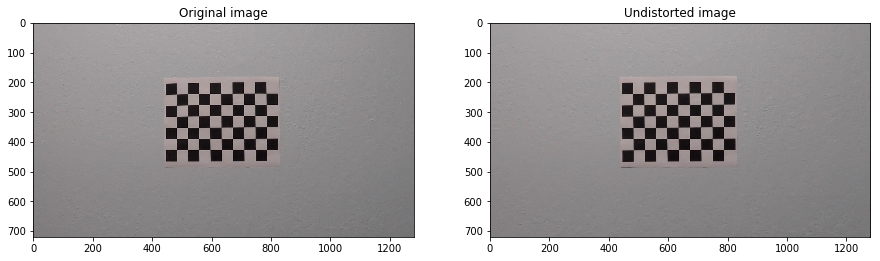

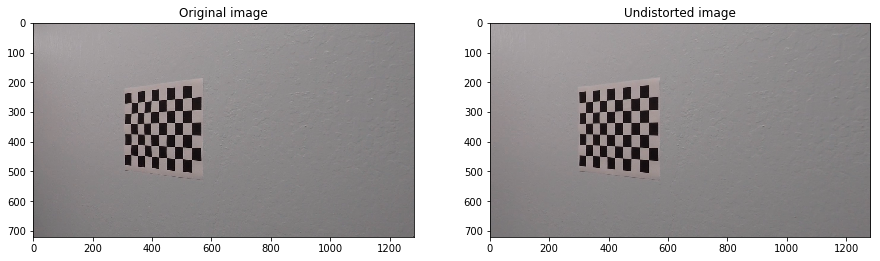

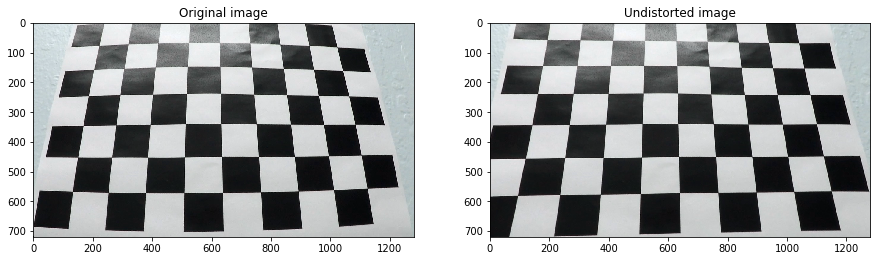

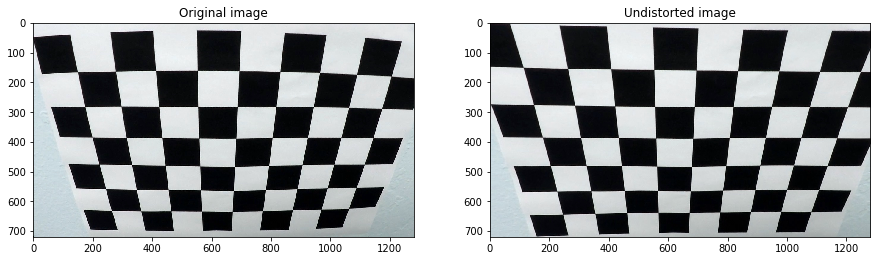

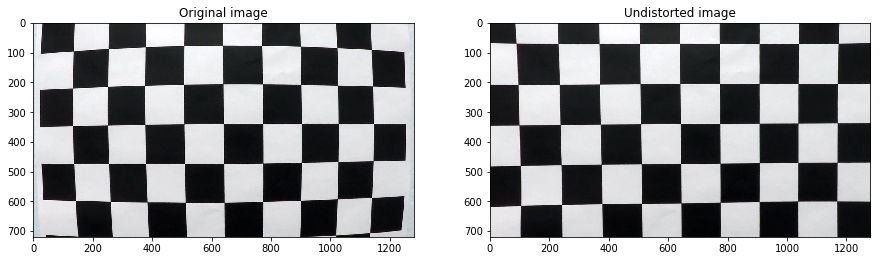

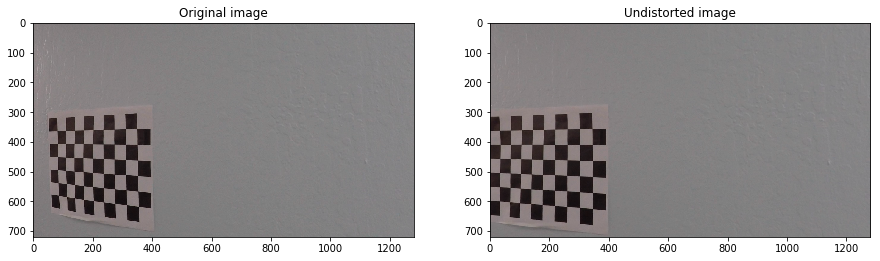

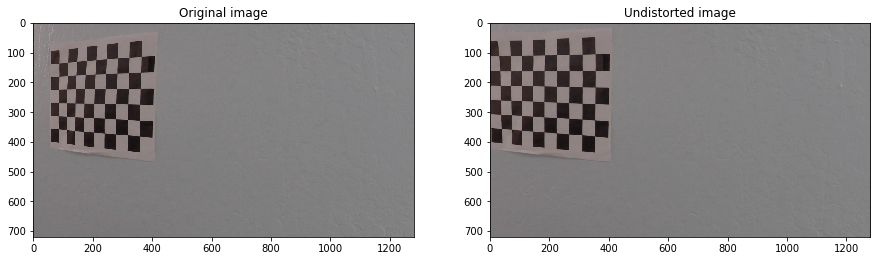

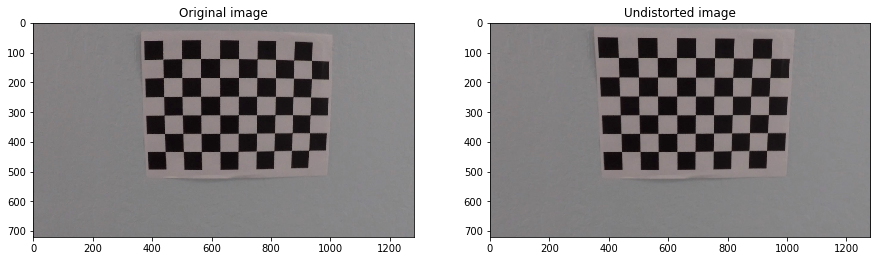

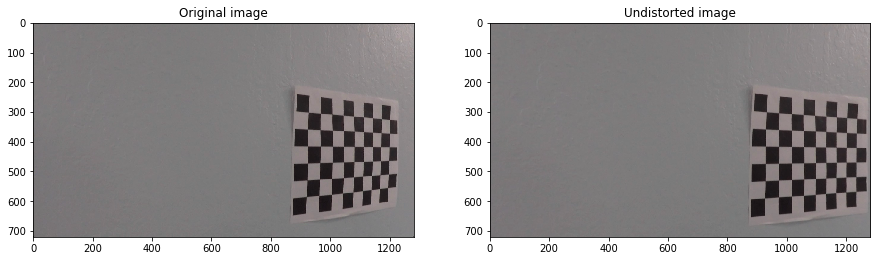

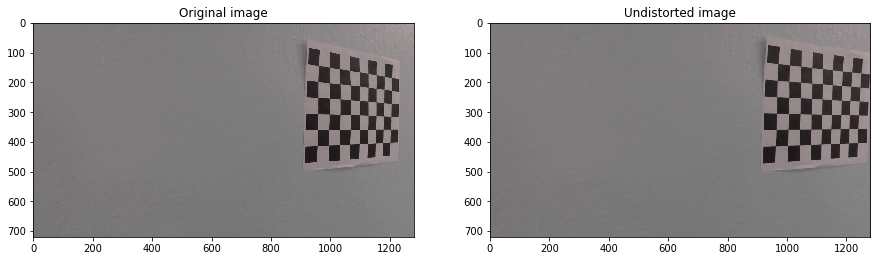

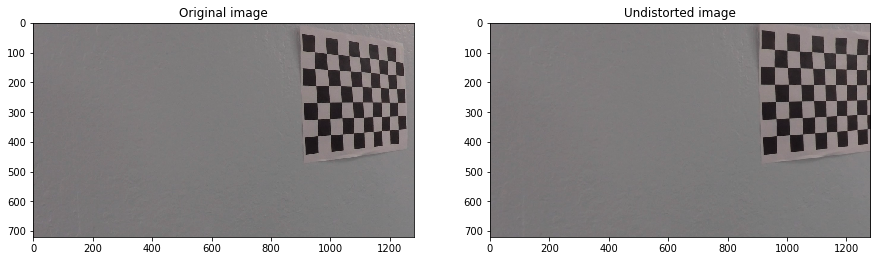

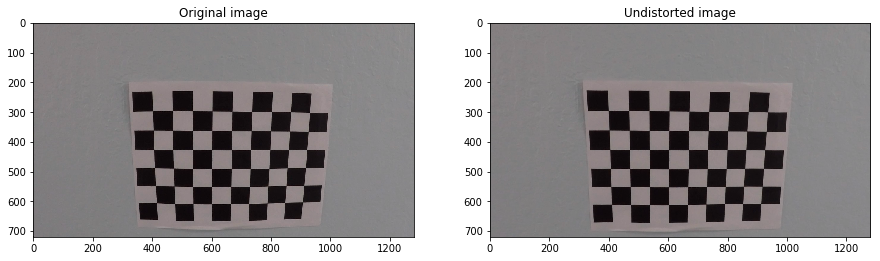

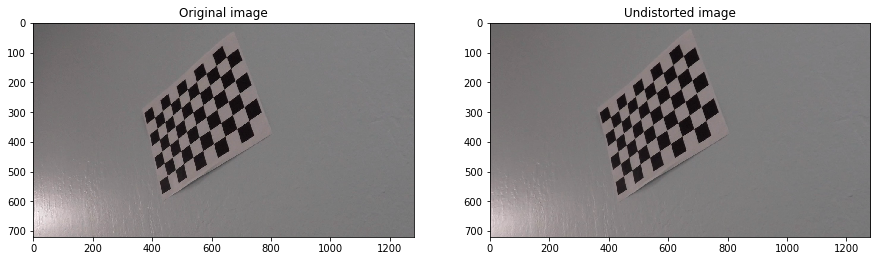

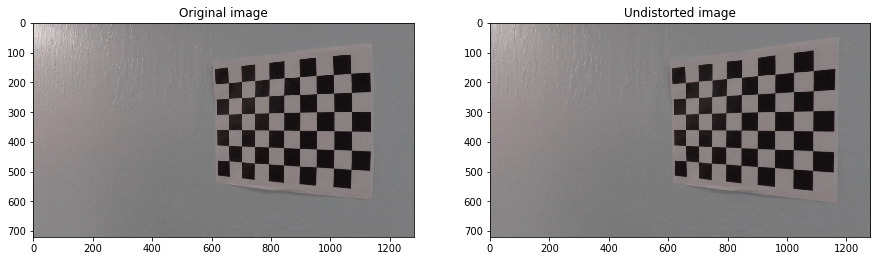

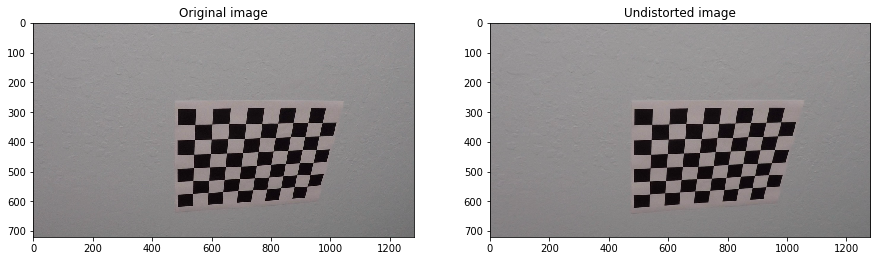

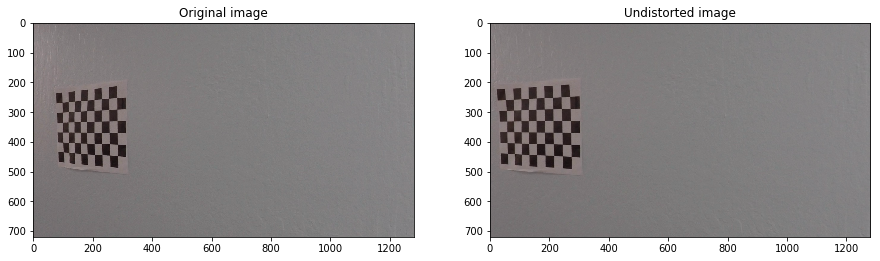

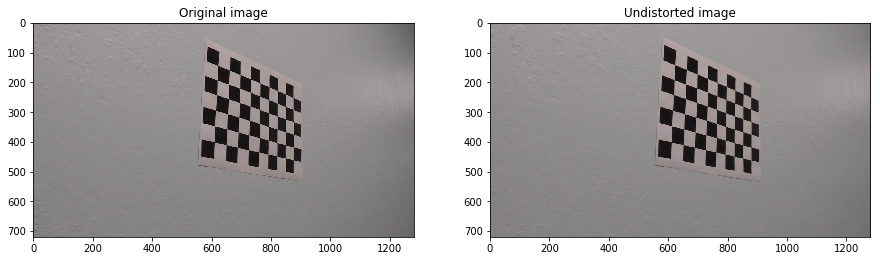

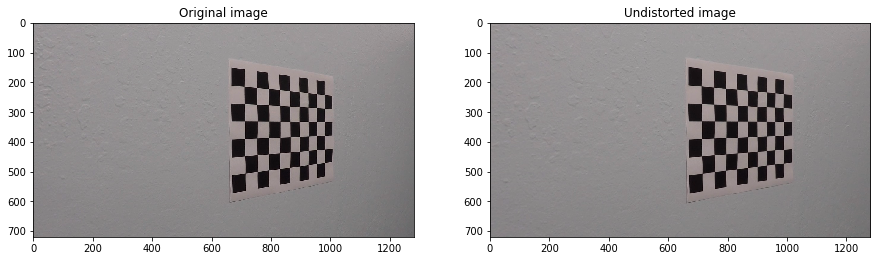

In [3]:
## applying the undistorting to each individual images
for image in imgContainer:
    img = cv2.imread(image)
    undistort = cal_undistort(img)
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(img)
    axs2.set_title("Undistorted image")
    axs2.imshow(undistort)

print("Completed")

### step - 3 Creating bird's eye view

In [4]:
# defining source points and destination points
imgHolder = glob.glob('test_images/*.jpg')

plt.imshow(testImage)
plt.plot(300,700, '.') #- left bottom
plt.plot(560,460, '.') #- top left
plt.plot(700,460,'.')  #- top right
plt.plot(1150,700,'.') #- right bottom
#srcPoints


def warp(img):
    img_size = (img.shape[1], img.shape[0])
    # creating the source points
    srcPoints = np.float32(
                [[300,700],
                 [560,460],
                 [700,460],
                 [1150,700]])
    dstPoints = np.float32(
                [[400,700],
                 [400,100],
                 [980,100],
                 [980,700]])
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M,  Minv

print("Completed")

NameError: name 'testImage' is not defined

In [ ]:
for img in imgHolder:
    image = cv2.imread(img)
    warped, M, Minv = warp(image)
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(warped)
    
print("Completed")

### step - 4 Gradient thresholding

In [ ]:
## applying sobel operator on the images
def sobel(img, orient='x', thresh_min = 0, thresh_max= 255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    return sxbinary
print("Completed")

In [ ]:
for img in imgHolder:
    image = cv2.imread(img)
    outSobel = sobel(image, orient='x', thresh_min=20, thresh_max=100)
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(outSobel, cmap='gray')

print("Completed")

In [ ]:
## Applying the magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

print("Completed")

In [ ]:
for img in imgHolder:
    image = cv2.imread(img)
    magSobel = mag_thresh(image, sobel_kernel=31, mag_thresh=(40, 100))
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(magSobel, cmap='gray')

print("Completed")

In [ ]:
## Applying direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

print("Completed")

In [ ]:
for img in imgHolder:
    image = cv2.imread(img)
    dirSobel= dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(dirSobel, cmap='gray')

print("Completed")

### step - 5 combining threshold

In [ ]:
def combined_threshold(img):
    image = cv2.imread(img)
    gradx = sobel(image, orient='x', thresh_min= 30, thresh_max = 100)
    grady = sobel(image, orient='y', thresh_min= 30, thresh_max = 100)
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(40, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

for img in imgHolder:
    combined = combined_threshold(img)
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(combined, cmap='gray')

print("Completed")

### step - 6 Color thresholds

In [ ]:
def rgb_thresh(img):
    R = image[:,:,0]
    G = image[:,:,1]
    thresh = (200, 255)
    binaryR = np.zeros_like(R)
    binaryR[(R > thresh[0]) & (R <= thresh[1])] = 1
    binaryG = np.zeros_like(G)
    binaryG[(G > thresh[0]) & (G <= thresh[1])] = 1
    return binaryR, binaryG

def hls_thresh(img):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]    
    thresh = (90, 255)
    binaryS = np.zeros_like(S)
    binaryS[(S > thresh[0]) & (S <= thresh[1])] = 1
    threshHLS = (15, 100)
    binaryH = np.zeros_like(H)
    binaryH[(H > threshHLS[0]) & (H <= threshHLS[1])] = 1
    return binaryS, binaryH

for img in imgHolder:
    image = cv2.imread(img)
    R, G = rgb_thresh(image)
    binaryS, binaryH = hls_thresh(image)
    f, (axs0, axs1, axs2, axs3, axs4) = plt.subplots(1, 5, figsize=(15,11))
    axs0.set_title("Original Image")
    axs0.imshow(image)
    axs1.set_title("RGB R-channel image")
    axs1.imshow(R, cmap = 'gray')
    axs2.set_title("RGB G-channel image")
    axs2.imshow(G, cmap='gray')
    axs3.set_title("HLS H-channel image")
    axs3.imshow(binaryS, cmap = 'gray')
    axs4.set_title("HLS S-channel image")
    axs4.imshow(binaryH, cmap = 'gray')
    
print("Completed")

In [ ]:
### step - 7 pipeline

In [ ]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return combined_binary


for img in imgHolder:
    image = cv2.imread(img)
    result = pipeline(image)
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
    axs1.set_title("Original image")
    axs1.imshow(image)
    axs2.set_title("Corner image")
    axs2.imshow(result, cmap='gray')

print("Completed")

### step - 8. Line Finding

In [ ]:
testWarpedImg = pipeline(warped)
plt.imshow(testWarpedImg, cmap='gray')
print("Completed")

In [ ]:
import numpy as np
histogram = np.sum(testWarpedImg[testWarpedImg.shape[0]//2:,:], axis=0)
plt.plot(histogram)
print("Completed")

In [ ]:
### Sliding window 
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzeroy, nonzerox 

print("Completed")

In [ ]:
### Visualization
binary_warped = testWarpedImg
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzeroy, nonzerox = sliding_window(binary_warped)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print("Completed")

In [ ]:
def advanceLane(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, ploty

print("Completed")

In [ ]:
### Visualize
margin = 100
left_fitx, right_fitx, left_lane_inds2, right_lane_inds2, ploty = advanceLane(binary_warped, left_fit, right_fit)
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print("Completed")

In [ ]:
# Create an image to draw the lines on
testImage = cv2.imread('./test_images/test5.jpg')
warped = pipeline(testImage)
plt.imshow(warped)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
warped, M, Minv = warp(testImage)

newwarp = cv2.warpPerspective(color_warp, Minv, (testImage.shape[1], testImage.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
plt.imshow(result)